## Compare population specific transcript identities 
## between Tau metric and discovery metric

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
print('test')

test


In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
# min_samples = 2
# min_cpm = 0.1
# tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
# min_cpm = 0.1
min_cpm = 1
min_samples = 1
# tau_df = pd.read_csv(f'241031_med_{min_cpm}_tau.tsv', sep='\t')
f = f'241108_{min_cpm}_{min_samples}_mean_tau.tsv'
print(f)
tau_df = pd.read_csv(f, sep='\t')

241108_1_1_mean_tau.tsv


In [5]:
# plot tau value vs. population specific transcripts
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [6]:
tau_df.head()

,tid,tau
0,transcript_6675,0.701495
1,transcript_6676,0.525534
2,transcript_6684,0.594136
3,transcript_11363,0.785230
4,transcript_11368,0.694987


In [7]:
tau_df = tau_df.merge(mt_df[['isoform', 'pop_spec_t']], 
                      how='left', 
                      left_on='tid',
                      right_on='isoform')

In [8]:
tau_df.head()

,tid,tau,isoform,pop_spec_t
0,transcript_6675,0.701495,transcript_6675,False
1,transcript_6676,0.525534,transcript_6676,False
2,transcript_6684,0.594136,transcript_6684,False
3,transcript_11363,0.785230,transcript_11363,False
4,transcript_11368,0.694987,transcript_11368,False


In [9]:
tau_df['pop_spec_t'] = tau_df['pop_spec_t'].fillna('Undefined')

In [10]:
len(tau_df.index)

43013

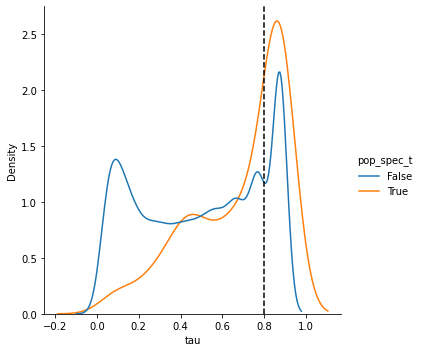

In [11]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')

In [13]:
len(tau_df.index)

43013

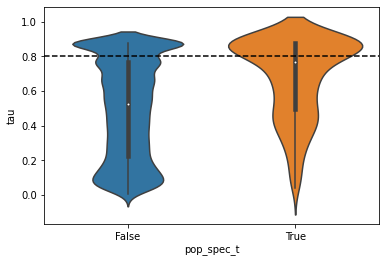

In [12]:
ax = sns.violinplot(tau_df, y='tau', x='pop_spec_t')
plt.axhline(0.8, color='k', linestyle='--')

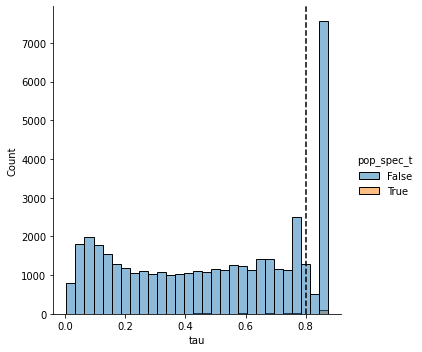

In [13]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t')
plt.axvline(0.8, color='k', linestyle='--')

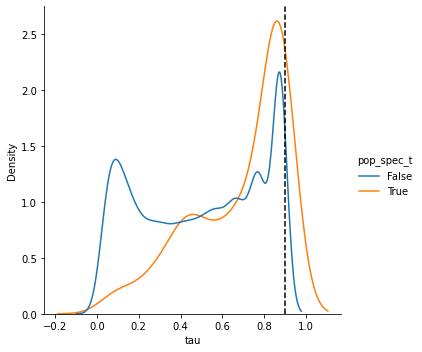

In [14]:
temp = tau_df.loc[tau_df.pop_spec_t!='Undefined']
ax = sns.displot(temp, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.9, color='k', linestyle='--')

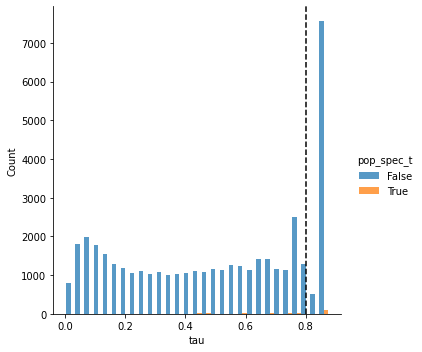

In [15]:
ax = sns.displot(temp, x='tau', hue='pop_spec_t',
                 multiple='dodge', edgecolor=None)
plt.axvline(0.8, color='k', linestyle='--')

In [14]:
tau_df['tau_pop_spec_t'] = tau_df.tau>=0.8

In [15]:
tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique()

tid
pop_spec_t tau_pop_spec_t       
False      False           34141
           True             8626
True       False             132
           True              114

In [16]:
tau_df[['tau_pop_spec_t', 'tid']].groupby(['tau_pop_spec_t']).nunique()

,tid
tau_pop_spec_t,
False,34273
True,8740


In [21]:
tau_df = tau_df.merge(mt_df[['isoform', 'structural_category']],
                      how='left',
                      left_on='tid',
                      right_on='isoform')
tau_df['novelty'] = 'Novel'
tau_df.loc[tau_df.structural_category=='FSM', 'novelty'] = 'Known'
tau_df[['tau_pop_spec_t',
        'novelty', 'tid']].groupby(['novelty',
                                       'tau_pop_spec_t']).nunique()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'isoform_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


tid
novelty tau_pop_spec_t       
Known   False           22092
        True             4586
Novel   False           12181
        True             4154

In [18]:
tau_df.loc[tau_df.tau_pop_spec_t, 'tau'].min()

0.8000027546516313

In [19]:
# tau_df.to_csv('241031_tau_0.1_min_cpm_0.8_min_tau.tsv', sep='\t')
tau_df.to_csv('241110_tau_1_min_cpm_0.8_min_tau.tsv', sep='\t')

In [20]:
## Fischer's exact test
temp = tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique().reset_index()

temp.head()
temp = temp.pivot(index='tau_pop_spec_t',
                  values = 'tid',
                  columns = 'pop_spec_t')
temp = temp.values
temp
# Perform Fisher's Exact Test
odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')


# # get the CI of these results
# result = st.contingency.odds_ratio(temp, kind='conditional')
# odds_ratio_value = result.statistic
# confidence_interval = result.confidence_interval(confidence_level=0.95)


print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)
# print("Conditional Odds Ratio:", odds_ratio_value)
# print("95% Confidence Interval:", confidence_interval)

Odds Ratio: 3.4182018422106526
P-value: 3.76753603645694e-20


In [21]:
temp

array([[34141,   132],
       [ 8626,   114]])

In [22]:
import scipy
scipy.__version__

'1.7.3'

In [23]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau'] # these should be higher
y = tau_df[tau_df['pop_spec_t'] == False]['tau'] # these should be lower

# alt hypothesis is that y > x or x < y

# ‘two-sided’: one of the distributions (underlying x or y) is stochastically greater than the other.

# ‘less’:  x < y.

# ‘greater’:  x > y.

# do the test
stat, p_value = st.ranksums(x, y,
                            alternative='greater')


print(f'Wilcoxon Rank Sum Test Statistic: {stat}')
print(f'P-value: {p_value}')


Wilcoxon Rank Sum Test Statistic: 10.225375272178116
P-value: 7.631780591274807e-25


In [24]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau']
y = tau_df[tau_df['pop_spec_t'] == False]['tau']

# Perform the Mann-Whitney U test
stat, p_value = st.mannwhitneyu(x, y,
                                alternative='greater')

print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U Test Statistic: 7246049.5
P-value: 5.674788192079838e-25


In [25]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau']
y = tau_df[tau_df['pop_spec_t'] == False]['tau']

# Perform the Mann-Whitney U test
stat, p_value = st.mannwhitneyu(x, y,
                                alternative='two-sided')

print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U Test Statistic: 7246049.5
P-value: 1.1349576384159675e-24


In [26]:
# can I get which population is the specific one? --> tune in next time in tau_post_hoc (I am great at naming notebooks)?

## Which transcripts are pop specific via detction and via expression?

In [28]:
tau_df.loc[tau_df.tid == 'transcript_148736']

,tid,tau,isoform,pop_spec_t,tau_pop_spec_t
11289,transcript_148736,0.875,transcript_148736,True,True
